In [1]:
"""
Created on Wed Aug  4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from main import *
debug_mode = True  # faster experiments for debugging

# util for getting objects' fields' names
field_names = lambda x: list(vars(x).keys())

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
dp.zmixOrthogonalPCAs()
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [ ]:
'''
Run the Model Experiments
'''

"""
model = 'PCDNN_V2'
assert model in ['PCDNN_V2', 'PCDNN_V1', 'SIMPLE_DNN', 'GP'] # valid possible models
exprExec=run_model_experiments(dm, models=model, debug_mode=debug_mode)
"""
exprExec = run_pcdnn_v2_experiments(dm, use_dependants=True, debug_mode = debug_mode)

In [5]:
""" prepare SimpleDNN for loading (from prior experiments) """

exprExec = DNNExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(SimpleDNNModelFactory())

Parent DNNModelFactory Instantiated


In [6]:
""" prepare PCDNNV1 for loading (from prior experiments) """

exprExec = PCDNNV1ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV1ModelFactory())

Parent DNNModelFactory Instantiated


In [30]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [ ]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dependants = 'NoDependants'
dataSetMethod = f'{inputType}_{dataType}_{dependants}'
opscaler = "MinMaxScaler"# 'PositiveLogNormal'
ZmixPresent = 'Y'
concatenateZmix = 'Y'
kernel_constraint = 'Y'
kernel_regularizer = 'Y'
activity_regularizer = 'Y'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='mae'
exprExec.modelFactory.activation_func='relu'
exprExec.modelFactory.dropout_rate=0.5
exprExec.debug_mode = False
exprExec.epochs_override = 5
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                 noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                 kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                 opscaler=opscaler)

## Results Plotting & Analysis

In [5]:
loss = 727684307.3417714 # Update Me!

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")
print_scientific_notation(loss)

Scientific Notation: 7.276843073417714*10^8


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.plot(np.maximum(history.history['val_R2'][30:], 0))
plt.title('val_R^2 vs epochs')
plt.ylabel('percent')
plt.xlabel('epochs')
plt.show()

In [ ]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
dm.createTrainTestData(experimentSettings['dataSetMethod'],experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {experimentSettings}')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)

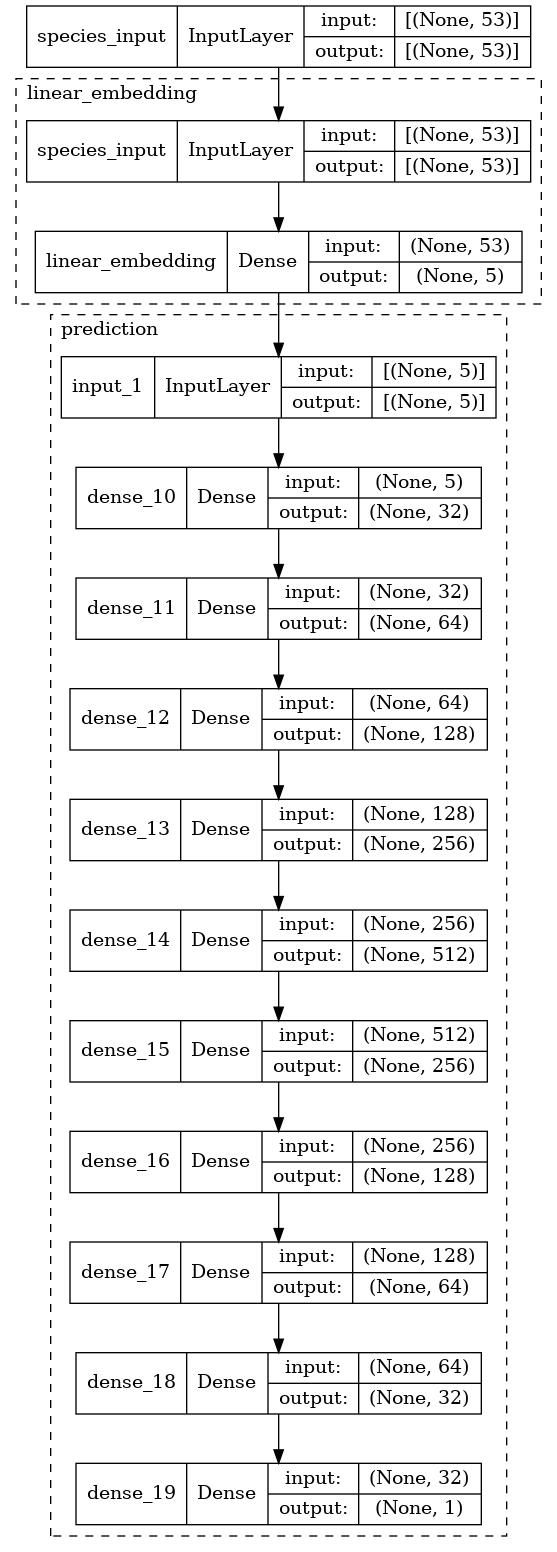

In [43]:
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

cpv4; 2.081850e-02 +/- 4.387942e-04
cpv2; 1.282845e-02 +/- 4.710283e-04
cpv1; 8.736847e-03 +/- 1.939559e-04
cpv5; 7.848289e-03 +/- 3.326863e-04
cpv3; 1.123923e-03 +/- 4.791079e-05


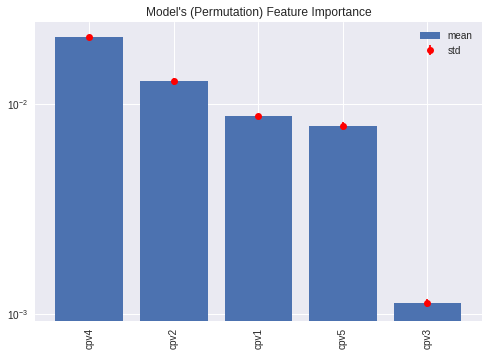

In [44]:
n_repeats = 20#5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

         cpv1      cpv2      cpv3      cpv4      cpv5
min -0.542938 -1.071296 -0.200100 -0.272706 -0.372884
25% -0.280895 -0.354129 -0.041531 -0.118797  0.071283
50% -0.132769 -0.231056  0.083858  0.007147  0.198770
75%  0.020319 -0.125254  0.232822  0.303622  0.334399
max  0.451908  0.036566  0.534275  0.662813  1.301544


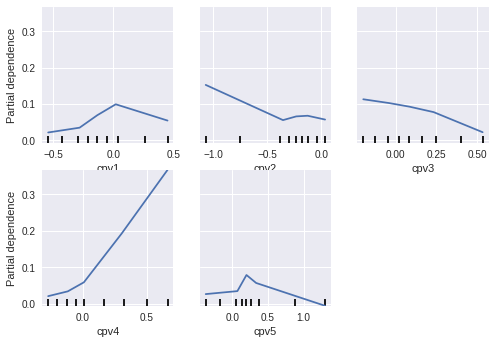

In [45]:
inspector.plot_partial_dependence()

#### Error Density by FlameId & XPos

In [46]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['actual'] = Y_test.flatten()

    evaluation_df_1['prediction'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['actual'] - evaluation_df_1['prediction']
   
    return evaluation_df_1['res'].values

/home/dwyerdei/.local/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['zmix'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


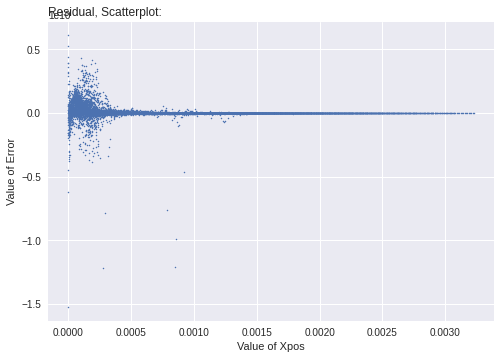

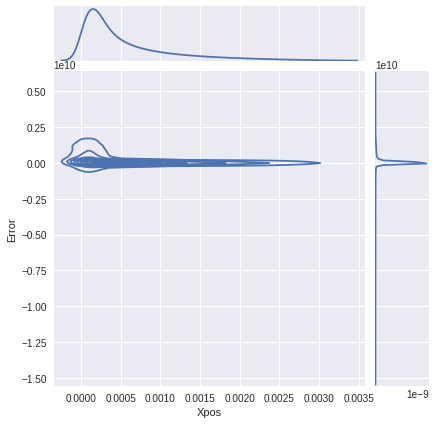

In [47]:
# TODO: Sanity check that this plots output ranges are correct? Seems like bug!

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X,Y,rom,Zmix = dm.getAllData()
#X_train, X_test, Y_train, Y_test, rom_train, rom_test, zmix_train, zmix_test = dm.getTrainTestData()
Y_test = Y
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, 0]
souener_test = opscaler.inverse_transform(Y_test)[:, 0]

#residual/error

residuals = getResiduals(souener_test,souener_pred)

Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"]=Xpos
plt_df["Error"] = residuals
# plot
plt.plot( 'Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Residual, Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')
#plt.title('Residual, Marginal Density plot:')

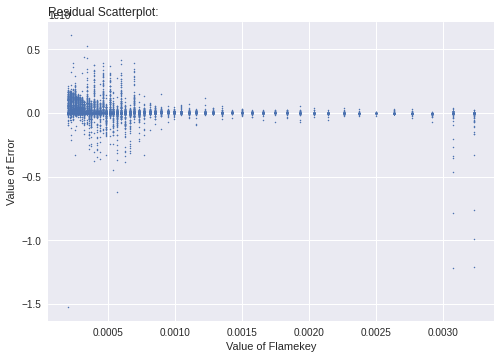

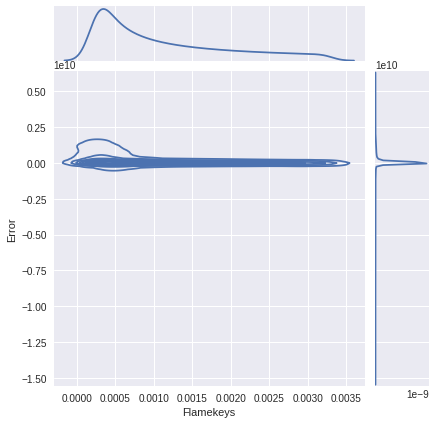

In [48]:
#residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

flamekeys = df['flame_key']#np.append(halfData["flame_keys_test"],halfData["flame_keys_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Flamekeys"]=flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Residual Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

Text(0.5, 1.0, 'Y_test histogram')

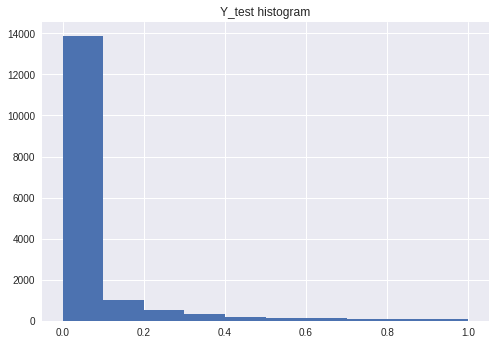

In [49]:
plt.hist(Y_test[:,0])
plt.title('Y_test histogram')

Text(0.5, 1.0, 'Y_pred histogram')

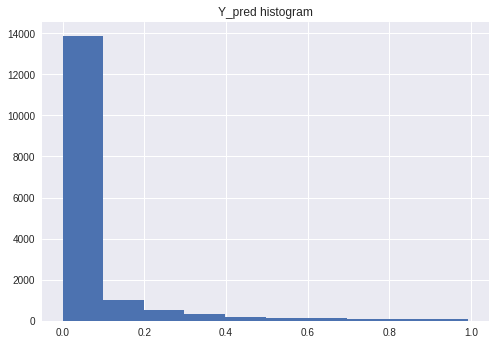

In [50]:
plt.hist(Y_pred[:,0])
plt.title('Y_pred histogram')

In [40]:
'''
from tensorflow import keras

def log_mse(x,y): return tf.math.log(tf.math.reduce_mean((x-y)**2))
def log_mae(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(x-y)))
def exp_mse_mag(x,y): return tf.math.log(tf.math.reduce_mean((tf.math.exp(x)-tf.math.exp(y))**2))/tf.math.log(10.0)
def exp_mae_mag(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(tf.math.exp(x)-tf.math.exp(y))))/tf.math.log(10.0)
def R2(yt,yp): return 1-tf.math.reduce_mean((yp-yt)**2)/(tf.math.reduce_std(yt)**2)
def exp_R2(yt,yp): # these are actual names above is for convenience
    return R2(tf.math.exp(yt), tf.math.exp(yp))

best_model = keras.models.load_model('long_train_perfect/long_train_best_model', custom_objects=locals())
best_model.save('models/best_models/PCDNNV2Model/model.h5', include_optimizer=False)

tf.keras.utils.plot_model(best_model, expand_nested=True, show_shapes=True)
'''